In [59]:
# Author: Rthvik Raviprakash
# Email: rravipra@uw.edu

# This notebook provides the code for calculating the AQI estimate:

# US EPA Air Quality System API

We are requesting data from the US Environmental Protection Agency (EPA) Air Quality Service (AQS) API. This is a historical API and does not provide real-time air quality data. The [documentation](https://aqs.epa.gov/aqsweb/documents/data_api.html) for the API provides definitions of the different call parameter and examples of the various calls that can be made to the API.

This notebook works systematically through example calls, requesting an API key, using 'list' to get various IDs and parameter values, and using 'daily summary' to get summary data that meets specific condistions. The notebook contains example function definitions that could be reused in other code. In general, the notebook explains each step along the way, referring back to possible output. Some of the explanations are tailored to the specific example requests of the API. Changing values to explore the results of the API is probably useful, but that will result in some explanations being out of sync with the outputs.

The US EPA was created in the early 1970's. The EPA reports that they only started broad based monitoring with standardized quality assurance procedures in the 1980's. Many counties will have data starting somewhere between 1983 and 1988. However, some counties still do not have any air quality monitoring stations. The API helps resolve this by providing calls to search for monitoring stations and data using either station ids, or a county designation or a geographic bounding box. This example code provides examples of the county based and bounding box based API calls. Some [additional information on the Air Quality System can be found in the EPA FAQ](https://www.epa.gov/outdoor-air-quality-data/frequent-questions-about-airdata) on the system.

The end goal of this example is to get to some values that we might use for the Air Quality Index or AQI. You might see this reported on the news, most often around smog, but more frequently with regard to smoke. The AQI index is meant to tell us something about how healthy or clean the air is on any day. The AQI is actually a somewhat complext measure. When I started this example I looked up [how to calculate the AQI](https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf) so that I would know roughly what goes into that value.


## License
Most parts of the code was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.1 - September 5, 2023

In [ ]:
#
#    These are standard python modules
#
#import json, time, urllib.parse
import json, time
#
#    The 'requests' module is a distribution module for making web requests.
#
import requests

In [2]:
#########
#
#    CONSTANTS
#

#
#    This is the root of all AQS API URLs
#
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

#
#    These are 'actions' we can ask the API to take or requests that we can make of the API
#
#    Sign-up request - generally only performed once - unless you lose your key
API_ACTION_SIGNUP = '/signup?email={email}'
#
#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'
#
#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    It is always nice to be respectful of a free data resource.
#    We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
#
#
#    This is a template that covers most of the parameters for the actions we might take, from the set of actions
#    above. In the examples below, most of the time parameters can either be supplied as individual values to a
#    function - or they can be set in a copy of the template and passed in with the template.
#
AQS_REQUEST_TEMPLATE = {
    "email":      "",
    "key":        "",
    "state":      "",     # the two digit state FIPS # as a string
    "county":     "",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}

Making a sign-up request

Before you can use the API you need to request a key. You will use an email address to make the request. The EPA then sends a confirmation email link and a 'key' that you use for all other requests.

You only need to sign-up once, unless you want to invalidate your current key (by getting a new key) or you lose your key.

In [5]:
#
#    This implements the sign-up request. The parameters are standardized so that this function definition matches
#    all of the others. However, the easiest way to call this is to simply call this function with your preferred
#    email address.
#

def request_signup(email_address = None,
                   endpoint_url = API_REQUEST_URL,
                   endpoint_action = API_ACTION_SIGNUP,
                   request_template = AQS_REQUEST_TEMPLATE,
                   headers = None):

    # Make sure we have a string - if you don't have access to this email addres, things might go badly for you
    if email_address:
        request_template['email'] = email_address
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_signup()'")

    # Compose the signup url - create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_action.format(**request_template)

    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

#
#    A SIGNUP request is only to be done once, to request a key. A key is sent to that email address and needs to be confirmed with a click through
#    This code should probably be commented out after you've made your key request to make sure you don't accidentally make a new sign-up request
#
#print("Requesting SIGNUP ...")
#response = request_signup("dwmc@uw.edu")
#print(json.dumps(response,indent=4))
#

In [4]:
#
#    A SIGNUP request is only to be done once, to request a key. A key is sent to that email address and needs to be confirmed with a click through
#    This code should probably be commented out after you've made your key request to make sure you don't accidentally make a new sign-up request
#
print("Requesting SIGNUP ...")
response = request_signup("rravipra@uw.edu")
print(json.dumps(response,indent=4))
#

Requesting SIGNUP ...
{
    "Header": [
        {
            "status": "Success",
            "request_time": "2023-11-08T21:48:06-05:00",
            "url": "https://aqs.epa.gov/data/api/signup?email=rravipra@uw.edu"
        }
    ],
    "Data": [
        "You should receive an email containing your new key shortly."
    ]
}


In [5]:
# key: aquacat41
# key: rubymouse85
# key: dunkit31
# key: silverfrog81

## Making a list request
Once you have a key, the next thing is to get information about the different types of air quality monitoring (sensors) and the different places where we might find air quality stations. The monitoring system is complex and changes all the time. The EPA implementation allows an API user to find changes to monitoring sites and sensors by making requests - maybe monthly, or daily. This API approach is probably better than having the EPA publish documentation that may be out of date as soon as it hits a web page. The one problem here is that some of the responses rely on jargon or terms-of-art. That is, one needs to know a bit about the way atmospheric sciece works to understand some of the terms. ... Good thing we can use the web to search for terms we don't know!

In [6]:
#
#    This implements the list request. There are several versions of the list request that only require email and key.
#    This code sets the default action/requests to list the groups or parameter class descriptors. Having those descriptors
#    allows one to request the individual (proprietary) 5 digit codes for individual air quality measures by using the
#    param request. Some code in later cells will illustrate those requests.
#
def request_list_info(email_address = None, key = None,
                      endpoint_url = API_REQUEST_URL,
                      endpoint_action = API_ACTION_LIST_CLASSES,
                      request_template = AQS_REQUEST_TEMPLATE,
                      headers = None):

    #  Make sure we have email and key - at least
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key

    # For the basic request we need an email address and a key
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_list_info()'")
    if not request_template['key']:
        raise Exception("Must supply a key to call 'request_list_info()'")

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)

    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

In [7]:
#
#   The default should get us a list of the various groups or classes of sensors. These classes are user defined names for clustors of
#   sensors that might be part of a package or default air quality sensing station. We need a class name to start getting down to the
#   a sensor ID. Each sensor type has an ID number. We'll eventually need those ID numbers to be able to request values that come from
#   that specific sensor.
#

USERNAME = "rravipra@uw.edu"
APIKEY = "silverfrog81"

request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY

response = request_list_info(request_template=request_data)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))

[
    {
        "code": "AIRNOW MAPS",
        "value_represented": "The parameters represented on AirNow maps (88101, 88502, and 44201)"
    },
    {
        "code": "ALL",
        "value_represented": "Select all Parameters Available"
    },
    {
        "code": "AQI POLLUTANTS",
        "value_represented": "Pollutants that have an AQI Defined"
    },
    {
        "code": "CORE_HAPS",
        "value_represented": "Urban Air Toxic Pollutants"
    },
    {
        "code": "CRITERIA",
        "value_represented": "Criteria Pollutants"
    },
    {
        "code": "CSN DART",
        "value_represented": "List of CSN speciation parameters to populate the STI DART tool"
    },
    {
        "code": "FORECAST",
        "value_represented": "Parameters routinely extracted by AirNow (STI)"
    },
    {
        "code": "HAPS",
        "value_represented": "Hazardous Air Pollutants"
    },
    {
        "code": "IMPROVE CARBON",
        "value_represented": "IMPROVE Carbon Parameters"
    }

We're interested in getting to something that might be the Air Quality Index (AQI). You see this reported on the news - often around smog values, but also when there is smoke in the sky. The AQI is a complex measure of different gasses and of the particles in the air (dust, dirt, ash ...).

From the list produced by our 'list/Classes' request above, it looks like there is a class of sensors called "AQI POLLUTANTS". Let's try to get a list of those specific sensors and see what we can get from those.

In [8]:
#
#   Once we have a list of the classes or groups of possible sensors, we can find the sensor IDs that make up that class (group)
#   The one that looks to be associated with the Air Quality Index is "AQI POLLUTANTS"
#   We'll use that to make another list request.
#
AQI_PARAM_CLASS = "AQI POLLUTANTS"

In [9]:
#
#   Structure a request to get the sensor IDs associated with the AQI
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['pclass'] = AQI_PARAM_CLASS  # here we specify that we want this 'pclass' or parameter classs

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_PARAMS)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))

[
    {
        "code": "42101",
        "value_represented": "Carbon monoxide"
    },
    {
        "code": "42401",
        "value_represented": "Sulfur dioxide"
    },
    {
        "code": "42602",
        "value_represented": "Nitrogen dioxide (NO2)"
    },
    {
        "code": "44201",
        "value_represented": "Ozone"
    },
    {
        "code": "81102",
        "value_represented": "PM10 Total 0-10um STP"
    },
    {
        "code": "88101",
        "value_represented": "PM2.5 - Local Conditions"
    },
    {
        "code": "88502",
        "value_represented": "Acceptable PM2.5 AQI & Speciation Mass"
    }
]


We should now have (above) a response containing a set of sensor ID numbers. The list should include the sensor numbers as well as a description or name for each sensor.

The EPA AQS API has limits on some call parameters. Specifically, when we request data for sensors we can only specify a maximum of 5 different sensor values to return. This means we cannot get all of the Air Quality Index parameters in one request for data. We have to break it up.

What I did below was to break the request into two logical groups, the AQI sensors that sample gasses and the AQI sensors that sample particles in the air.

In [10]:
#
#   Given the set of sensor codes, now we can create a parameter list or 'param' value as defined by the AQS API spec.
#   It turns out that we want all of these measures for AQI, but we need to have two different param constants to get
#   all seven of the code types. We can only have a max of 5 sensors/values request per param.
#
#   Gaseous AQI pollutants CO, SO2, NO2, and O3
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"
#
#   Particulate AQI pollutants PM10, PM2.5, and Acceptable PM2.5
AQI_PARAMS_PARTICULATES = "81102,88101,88502"
#
#

Air quality monitoring stations are located all over the US at different locations. We will need some sample locations to experiment with different locations to see what kinds of values come back from different sensor requests.

This list includes the [FIPS](https://www.census.gov/library/reference/code-lists/ansi.html) number for the state and county as a 5 digit string. This format, the 5 digit string, is a 'old' format that is still widely used. There are new codes that may eventually be adopted for the US government information systems. But FIPS is currently what the AQS uses, so that's what is in the list as the constant.

In [11]:
#
#   We'll use Helena in Montana
#
CITY_LOCATIONS = {
    'helena' :       {'city'   : 'Helena',
                      'county' : 'Lewis and Clark County',
                      'state'  : 'Montana',
                      'fips'   : '30049',
                      'latlon' : [46.592648, -112.036903] }
}

Given our CITY_LOCATIONS constant we can now find which monitoring locations are nearby. One option is to use the county to define the area we're interest in. You can get the EPA to list their monitoring stations by county. You can also get a set of monitoring stations by using a bounding box of latitude, longitude points. For this example, we'll use the county approach. There is a bounding box example later in this notebook.

In [12]:
#
#  This list request should give us a list of all the monitoring stations in the county specified by the
#  given city selected from the CITY_LOCATIONS dictionary
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS['helena']['fips'][:2]   # the first two digits (characters) of FIPS is the state code
request_data['county'] = CITY_LOCATIONS['helena']['fips'][2:]  # the last three digits (characters) of FIPS is the county code

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_SITES)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))

[
    {
        "code": "0001",
        "value_represented": null
    },
    {
        "code": "0002",
        "value_represented": null
    },
    {
        "code": "0003",
        "value_represented": null
    },
    {
        "code": "0004",
        "value_represented": "NCORE - Sieben Flats"
    },
    {
        "code": "0006",
        "value_represented": null
    },
    {
        "code": "0007",
        "value_represented": null
    },
    {
        "code": "0008",
        "value_represented": null
    },
    {
        "code": "0009",
        "value_represented": null
    },
    {
        "code": "0011",
        "value_represented": null
    },
    {
        "code": "0012",
        "value_represented": null
    },
    {
        "code": "0013",
        "value_represented": null
    },
    {
        "code": "0014",
        "value_represented": null
    },
    {
        "code": "0015",
        "value_represented": null
    },
    {
        "code": "0016",
        "value_represented"


The above response gives us a list of monitoring stations. Each monitoring station has a unique "code" which is a string number, and, sometimes, a description. The description seems to be something about where the monitoring station is located.


The function below is designed to encapsulate requests to the EPA AQS API. When calling the function one should create/copy a parameter template, then initialize that template with values that won't change with each call. Then on each call simply pass in the parameters that need to change, like date ranges.

Another function below provides an example of extracting values and restructuring the response to make it a little more usable.

In [13]:
#
#    This implements the daily summary request. Daily summary provides a daily summary value for each sensor being requested
#    from the start date to the end date.
#
#    Like the two other functions, this can be called with a mixture of a defined parameter dictionary, or with function
#    parameters. If function parameters are provided, those take precedence over any parameters from the request template.
#
def request_daily_summary(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL,
                          endpoint_action = API_ACTION_DAILY_SUMMARY_COUNTY,
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):

    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']:
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']:
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']:
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']:
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
    # Note we're not validating FIPS fields because not all of the daily summary actions require the FIPS numbers

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)

    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

The below code checks for what years do we have data for gaseous and particulate data and for both:

In [14]:
years_with_gaseous_data = []
years_with_particulate_data = []
years_with_both_types_of_data = []

for year in range(1963, 2024):
    data_for_year = {'gaseous': False, 'particulate': False}

    # Set up the date range for the fire season of the current year
    begin_date = f"{year}0501"  # May 1st
    end_date = f"{year}1031"    # October 31st

    # Copy the request template and update it for the current year
    request_data = AQS_REQUEST_TEMPLATE.copy()
    request_data['email'] = USERNAME
    request_data['key'] = APIKEY
    request_data['state'] = CITY_LOCATIONS['helena']['fips'][:2]
    request_data['county'] = CITY_LOCATIONS['helena']['fips'][2:]

    # Gaseous pollutants
    request_data['param'] = AQI_PARAMS_GASEOUS
    gaseous_aqi = request_daily_summary(request_template=request_data, begin_date=begin_date, end_date=end_date)
    if gaseous_aqi["Header"][0]['status'] == "Success":
        data_for_year['gaseous'] = True
        years_with_gaseous_data.append(year)
    elif not gaseous_aqi["Header"][0]['status'].startswith("No data"):
        print(f"Error in response for gaseous pollutants in {year}: {json.dumps(gaseous_aqi, indent=4)}")

    # Particulate pollutants
    request_data['param'] = AQI_PARAMS_PARTICULATES
    particulate_aqi = request_daily_summary(request_template=request_data, begin_date=begin_date, end_date=end_date)
    if particulate_aqi["Header"][0]['status'] == "Success":
        data_for_year['particulate'] = True
        years_with_particulate_data.append(year)
    elif not particulate_aqi["Header"][0]['status'].startswith("No data"):
        print(f"Error in response for particulate pollutants in {year}: {json.dumps(particulate_aqi, indent=4)}")

    # Check if both data types are available for the year
    if data_for_year['gaseous'] and data_for_year['particulate']:
        years_with_both_types_of_data.append(year)

# After the loop
print("Years with gaseous data:", years_with_gaseous_data)
print("Years with particulate data:", years_with_particulate_data)
print("Years with both types of data:", years_with_both_types_of_data)

Years with gaseous data: [1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
Years with particulate data: [1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
Years with both types of data: [1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


In [15]:
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['param'] = AQI_PARAMS_GASEOUS
request_data['state'] = CITY_LOCATIONS['helena']['fips'][:2]
request_data['county'] = CITY_LOCATIONS['helena']['fips'][2:]

# request daily summary data for the month of July in 2021
gaseous_aqi = request_daily_summary(request_template=request_data, begin_date="19860501", end_date="19861031")
print("Response for the gaseous pollutants ...")
#
if gaseous_aqi["Header"][0]['status'] == "Success":
    print(json.dumps(gaseous_aqi['Data'],indent=4))
elif gaseous_aqi["Header"][0]['status'].startswith("No data "):
    print("Looks like the response generated no data. You might take a closer look at your request and the response data.")
else:
    print(json.dumps(gaseous_aqi,indent=4))

request_data['param'] = AQI_PARAMS_PARTICULATES
# request daily summary data for the month of July in 2021
particulate_aqi = request_daily_summary(request_template=request_data, begin_date="19860501", end_date="19861031")
print("Response for the particulate pollutants ...")
#
if particulate_aqi["Header"][0]['status'] == "Success":
    print(json.dumps(particulate_aqi['Data'],indent=4))
elif particulate_aqi["Header"][0]['status'].startswith("No data "):
    print("Looks like the response generated no data. You might take a closer look at your request and the response data.")
else:
    print(json.dumps(particulate_aqi,indent=4))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Response for the particulate pollutants ...
[
    {
        "state_code": "30",
        "county_code": "049",
        "site_number": "0001",
        "parameter_code": "81102",
        "poc": 1,
        "latitude": 46.584622,
        "longitude": -112.015601,
        "datum": "WGS84",
        "parameter": "PM10 Total 0-10um STP",
        "sample_duration_code": "7",
        "sample_duration": "24 HOUR",
        "pollutant_standard": "PM10 24-hour 2006",
        "date_local": "1986-05-14",
        "units_of_measure": "Micrograms/cubic meter (25 C)",
        "event_type": "No Events",
        "observation_count": 1,
        "observation_percent": 100.0,
        "validity_indicator": "Y",
        "arithmetic_mean": 14.0,
        "first_max_value": 14.0,
        "first_max_hour": 0,
        "aqi": 13,
        "method_code": "052",
        "method": "HI-VOL-SA321A - GRAVIMETRIC",
        "local_site_name": null,
        "site_address": "COGSWELL BLDG, 1401 LOCKEY",
        "state": "Montana"

The form of the daily summary response is a bit verbose with lots of repeated values. What we'll do is create a data structure that relies on a hierarchical context to summarize the data.

The next function takes the response and a set of fields that should be extracted for their data values. The code assumes those fields are available. If there are missing values something could certainly go wrong. The function creates a summary for each monitoring site.

In [16]:
#
#    This is a list of field names - data - that will be extracted from each record
#
EXTRACTION_FIELDS = ['date_local', 'date_of_last_change', 'sample_duration','observation_count','arithmetic_mean','aqi']

#
#    The function creates a summary record
def extract_summary_from_response(r=None, fields=EXTRACTION_FIELDS):
    ## the result will be structured around monitoring site, parameter, and then date
    result = dict()
    data = r["Data"]
    for record in data:
        # make sure the record is set up
        site = record['site_number']
        param = record['parameter_code']
        #date = record['date_local']    # this version keeps the respnse value YYYY-
        date = record['date_local'].replace('-','') # this puts it in YYYYMMDD format
        if site not in result:
            result[site] = dict()
            result[site]['local_site_name'] = record['local_site_name']
            result[site]['site_address'] = record['site_address']
            result[site]['state'] = record['state']
            result[site]['county'] = record['county']
            result[site]['city'] = record['city']
            result[site]['pollutant_type'] = dict()
        if param not in result[site]['pollutant_type']:
            result[site]['pollutant_type'][param] = dict()
            result[site]['pollutant_type'][param]['parameter_name'] = record['parameter']
            result[site]['pollutant_type'][param]['units_of_measure'] = record['units_of_measure']
            result[site]['pollutant_type'][param]['method'] = record['method']
            result[site]['pollutant_type'][param]['data'] = dict()
        if date not in result[site]['pollutant_type'][param]['data']:
            result[site]['pollutant_type'][param]['data'][date] = list()

        # now extract the specified fields
        extract = dict()
        for k in fields:
            if str(k) in record:
                extract[str(k)] = record[k]
            else:
                # this makes sure we always have the requested fields, even if
                # we have a missing value for a given day/month
                extract[str(k)] = None

        # add this extraction to the list for the day
        result[site]['pollutant_type'][param]['data'][date].append(extract)

    return result

In [17]:
extract_gaseous = extract_summary_from_response(gaseous_aqi)
print("Summary of gaseous extraction ...")
print(json.dumps(extract_gaseous,indent=4))

Summary of gaseous extraction ...
{
    "0701": {
        "local_site_name": null,
        "site_address": "ASARCO-KLEFFNER ROAD, EAST HELENA",
        "state": "Montana",
        "county": "Lewis and Clark",
        "city": "East Helena",
        "pollutant_type": {
            "42401": {
                "parameter_name": "Sulfur dioxide",
                "units_of_measure": "Parts per billion",
                "method": "INSTRUMENTAL - PULSED FLUORESCENT",
                "data": {
                    "19860501": [
                        {
                            "date_local": "1986-05-01",
                            "date_of_last_change": "2021-11-10",
                            "sample_duration": "1 HOUR",
                            "observation_count": 7,
                            "arithmetic_mean": 0.0,
                            "aqi": 0
                        },
                        {
                            "date_local": "1986-05-01",
                       

In [18]:
extract_particulate = extract_summary_from_response(particulate_aqi)
print("Summary of particulate extraction ...")
print(json.dumps(extract_particulate,indent=4))

Summary of particulate extraction ...
{
    "0001": {
        "local_site_name": null,
        "site_address": "COGSWELL BLDG, 1401 LOCKEY",
        "state": "Montana",
        "county": "Lewis and Clark",
        "city": "Helena",
        "pollutant_type": {
            "81102": {
                "parameter_name": "PM10 Total 0-10um STP",
                "units_of_measure": "Micrograms/cubic meter (25 C)",
                "method": "HI-VOL-SA321A - GRAVIMETRIC",
                "data": {
                    "19860514": [
                        {
                            "date_local": "1986-05-14",
                            "date_of_last_change": "2021-11-09",
                            "sample_duration": "24 HOUR",
                            "observation_count": 1,
                            "arithmetic_mean": 14.0,
                            "aqi": 13
                        },
                        {
                            "date_local": "1986-05-14",
               

The code below calculates the avearge AQI estimates for both gaseous and the particulate for the years 1986 - 2023 since only from 1986-2023 we have data for both.

In [19]:
import json
from collections import defaultdict

# Other necessary imports and initial setups (like API keys, request templates, etc.)

gaseous_data = []
particulate_data = []

# Loop through each year from 1986 to 2023
for year in range(1986, 2024):
    # Set dates for May 1st to October 31st of the current year
    begin_date = f"{year}0501"
    end_date = f"{year}1031"

    # Update request data for gaseous pollutants
    request_data['param'] = AQI_PARAMS_GASEOUS
    request_data['begin_date'] = begin_date
    request_data['end_date'] = end_date
    gaseous_aqi = request_daily_summary(request_template=request_data)
    extract_gaseous = extract_summary_from_response(gaseous_aqi)
    gaseous_data.append(extract_gaseous)

    # Update request data for particulate pollutants
    request_data['param'] = AQI_PARAMS_PARTICULATES
    request_data['begin_date'] = begin_date
    request_data['end_date'] = end_date
    particulate_aqi = request_daily_summary(request_template=request_data)
    extract_particulate = extract_summary_from_response(particulate_aqi)
    particulate_data.append(extract_particulate)

# Assuming the extraction functions work as intended and return the required data format

def extract_aqi_by_year(data):
    aqi_by_year = defaultdict(list)
    for year_data in data:
        for site_data in year_data.values():
            for pollutant in site_data['pollutant_type'].values():
                for date, observations in pollutant['data'].items():
                    year = date[:4]  # Extract year from 'YYYYMMDD'
                    for observation in observations:
                        if observation['aqi'] is not None:
                            aqi_by_year[year].append(observation['aqi'])
    return aqi_by_year

def calculate_yearly_aqi_average(aqi_by_year):
    yearly_average_aqi = {}
    for year, aqis in aqi_by_year.items():
        if aqis:
            average_aqi = sum(aqis) / len(aqis)
            yearly_average_aqi[year] = average_aqi
    return yearly_average_aqi

# Extract and compute averages for both gaseous and particulate data
gaseous_aqi_by_year = extract_aqi_by_year(gaseous_data)
particulate_aqi_by_year = extract_aqi_by_year(particulate_data)

yearly_average_aqi_gaseous = calculate_yearly_aqi_average(gaseous_aqi_by_year)
yearly_average_aqi_particulate = calculate_yearly_aqi_average(particulate_aqi_by_year)

# Output the results
print("Yearly Average AQI for Gaseous Pollutants:")
print(json.dumps(yearly_average_aqi_gaseous, indent=4))

print("\nYearly Average AQI for Particulate Pollutants:")
print(json.dumps(yearly_average_aqi_particulate, indent=4))

Yearly Average AQI for Gaseous Pollutants:
{
    "1986": 49.87465940054496,
    "1987": 52.76470588235294,
    "1988": 44.57367668097282,
    "1989": 49.126547455295736,
    "1990": 55.19836956521739,
    "1991": 47.74320652173913,
    "1992": 64.1304347826087,
    "1993": 32.53747714808044,
    "1994": 64.2167577413479,
    "1995": 53.029038112522684,
    "1996": 35.51548269581056,
    "1997": 37.927570093457945,
    "1998": 41.192934782608695,
    "1999": 40.6158038147139,
    "2000": 53.703804347826086,
    "2001": 3.727272727272727,
    "2011": 21.86924493554328,
    "2012": 18.288444040036396,
    "2013": 18.494902687673772,
    "2014": 19.64162895927602,
    "2015": 21.245039682539684,
    "2016": 19.876080691642652,
    "2017": 24.847826086956523,
    "2018": 21.19121683440073,
    "2019": 19.42726440988106,
    "2020": 20.396883593033913,
    "2021": 24.447679708826204,
    "2022": 20.772232304900182,
    "2023": 23.678474114441418
}

Yearly Average AQI for Particulate Pollutan

Now to find a final value for the AQI estimate we are going to take the maximum value of the AQI estimate between the gaseous and the particulate values:

In [20]:
combined_aqi = {}
for year in yearly_average_aqi_gaseous.keys():
    gaseous_aqi = yearly_average_aqi_gaseous.get(year, 0)
    particulate_aqi = yearly_average_aqi_particulate.get(year, 0)
    combined_aqi[year] = max(gaseous_aqi, particulate_aqi)

# Print the combined AQI
for year, aqi in combined_aqi.items():
    print(f"Year {year}: Combined AQI = {aqi}")

Year 1986: Combined AQI = 49.87465940054496
Year 1987: Combined AQI = 52.76470588235294
Year 1988: Combined AQI = 44.57367668097282
Year 1989: Combined AQI = 49.126547455295736
Year 1990: Combined AQI = 55.19836956521739
Year 1991: Combined AQI = 47.74320652173913
Year 1992: Combined AQI = 64.1304347826087
Year 1993: Combined AQI = 32.53747714808044
Year 1994: Combined AQI = 64.2167577413479
Year 1995: Combined AQI = 53.029038112522684
Year 1996: Combined AQI = 35.51548269581056
Year 1997: Combined AQI = 37.927570093457945
Year 1998: Combined AQI = 41.192934782608695
Year 1999: Combined AQI = 40.6158038147139
Year 2000: Combined AQI = 53.703804347826086
Year 2001: Combined AQI = 21.960509554140128
Year 2011: Combined AQI = 22.963143254520165
Year 2012: Combined AQI = 36.904805077062555
Year 2013: Combined AQI = 24.96980589503954
Year 2014: Combined AQI = 21.659698423577794
Year 2015: Combined AQI = 32.74974806852536
Year 2016: Combined AQI = 19.876080691642652
Year 2017: Combined AQI =

Now for us to plot both the AQI estimates and the smoke impact estimates I first load the json files that has the data for the smoke impacts generated from the code in Calculate_smoke_impact.ipynb.

In [21]:
# Load the smoke impact data from the file
with open('annual_smoke_impact_final.json', 'r') as file:
    annual_smoke_impact = json.load(file)

# Compute the average smoke impact for each year
average_smoke_impact = {}
for year, impacts in annual_smoke_impact.items():
    if impacts:  # ensuring the list is not empty
        average_impact = sum(impacts) / len(impacts)
        average_smoke_impact[year] = average_impact

In [22]:
# A function to normalize a list of values using min-max normalization:
def normalize(values):
    min_val = min(values)
    max_val = max(values)
    if max_val - min_val == 0:  # To handle the case where all values are the same
        return [0 for _ in values]
    
    return [(val - min_val) / (max_val - min_val) for val in values]

In [29]:
average_smoke_impact

{'1963': 0.007746466322349359,
 '1964': 0.004715837418752645,
 '1965': 0.004851681933679964,
 '1966': 0.016419431918595215,
 '1967': 0.013076970829510039,
 '1968': 0.00812175076367962,
 '1969': 0.007104625131954668,
 '1970': 0.008692553437374885,
 '1971': 0.014559049849759484,
 '1972': 0.00473058267449343,
 '1973': 0.015396973449192131,
 '1974': 0.003728189388740233,
 '1975': 0.0035410795857873777,
 '1976': 0.005099892406687633,
 '1977': 0.0030637678620890865,
 '1978': 0.004593854753387357,
 '1979': 0.015276490382965578,
 '1980': 0.0036952395106999714,
 '1981': 0.016613415625182586,
 '1982': 0.0039673228585688555,
 '1983': 0.0081855618144019,
 '1984': 0.18584395325387132,
 '1985': 0.01775264796525581,
 '1986': 0.01125835389265813,
 '1987': 0.0070273460717218015,
 '1988': 0.4367106608341205,
 '1989': 0.008508347548104105,
 '1990': 0.025686032177121065,
 '1991': 0.013491241575790841,
 '1992': 0.01380545075937515,
 '1993': 0.002428902562245062,
 '1994': 0.023795581460602438,
 '1995': 0.00

Before plotting I normalize the values for both the smoke impact estimate and the AQI impact estiamte and then I plot:
3. A time series graph containing your fire smoke estimate for your city and the AQI estimate for your city.

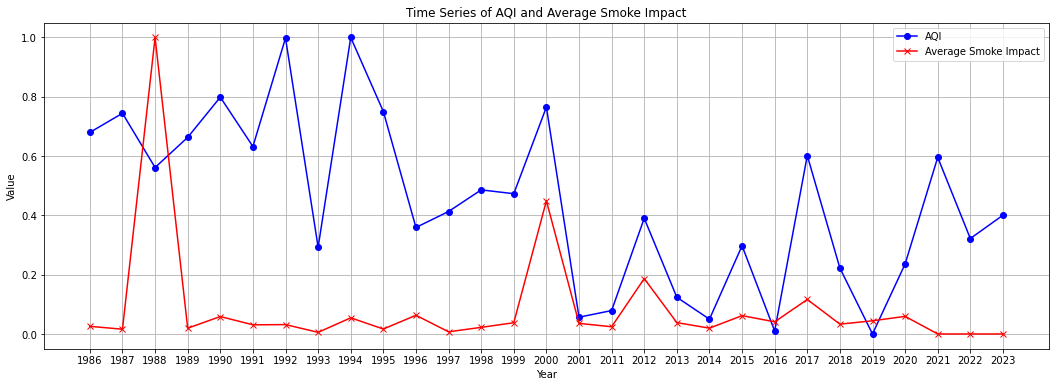

In [23]:
import matplotlib.pyplot as plt

# Assuming combined_aqi is already computed as shown in your code
combined_aqi = {}
for year in yearly_average_aqi_gaseous.keys():
    gaseous_aqi = yearly_average_aqi_gaseous.get(year, 0)
    particulate_aqi = yearly_average_aqi_particulate.get(year, 0)
    combined_aqi[year] = max(gaseous_aqi, particulate_aqi)

# Preparing data for plotting
years = sorted(combined_aqi.keys())
aqi_values = normalize([combined_aqi[year] for year in years])
smoke_impact_values = normalize([average_smoke_impact.get(str(year), 0) for year in years])

# Plotting
plt.figure(figsize=(18, 6))
plt.plot(years, aqi_values, label='AQI', color='blue', marker='o')
plt.plot(years, smoke_impact_values, label='Average Smoke Impact', color='red', marker='x')

plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Time Series of AQI and Average Smoke Impact')
plt.legend()
plt.grid(True)
plt.show()

## Predictive model to predict the next 25 years of data:

For my model I use an Exponential smoothing model using the average smoke impact data that we generated:

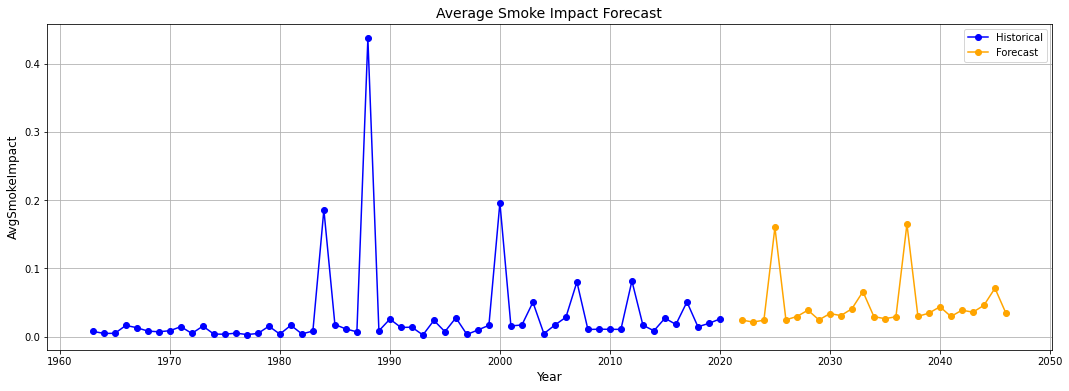

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Convert to DataFrame
df = pd.DataFrame(list(average_smoke_impact.items()), columns=['Year', 'AvgSmokeImpact'])
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index('Year', inplace=True)

# Holt-Winters Exponential Smoothing model
model = ExponentialSmoothing(df, trend='add', seasonal='add', seasonal_periods=12)
result = model.fit()

# Forecast the next 25 years
forecast = result.forecast(steps=25)
forecast_df = pd.DataFrame(forecast)
forecast_df.columns = ['Forecast']
forecast_df.index = pd.date_range(start=df.index[-1], periods=26, freq='Y')[1:]

# Plotting with modifications
plt.figure(figsize=(18, 6))
plt.plot(df, marker='o', label='Historical', color='blue')
plt.plot(forecast_df, marker='o', label='Forecast', color='orange')
plt.title('Average Smoke Impact Forecast', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('AvgSmokeImpact', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

In [67]:
# Forecasted values of the next 29 years since I only had data until the year 2020 so I have predicted until the year 2049,
# but at the same time it consists of the 25 year prediction:

In [68]:
# the forecasted values:
forecast_df

,Forecast
2021-12-31,0.024282
2022-12-31,0.021353
2023-12-31,0.024057
2024-12-31,0.159897
2025-12-31,0.024695
2026-12-31,0.029430
2027-12-31,0.038791
2028-12-31,0.024525
2029-12-31,0.033750
2030-12-31,0.030836
